# Titanic Project 
 Hello fellow kagglers. This is my first project on kaggle (like every other user) and I am sharing my approach 
 for predicting survival of Titanic passengers.
 We will follow the following steps : 
-  Pick a variable 
-  Do univariate/Multivariate analysis
-  Build a classification Model (Decision trees)
-  Use cross-validation technique(25 fold) so that we are able to generalize the model and avoid overfitting. 
-  Add another variable and loop through the above steps.
  

Lets Start with loading our train and test data. I will be using seaborn for plotting and visualization.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Lets have a look at the general information of our training data

In [2]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are total 12 columns(potential features) with 891 training examples. The features Age,Cabin,Embarked have missing values which we will deal later. Lets look at first 5 training examples.

In [3]:
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived is our target variable. PassengerId is just the id given to each passengers. It doesn't influence survival of a person in any way therefore no need to consider it as a feature. Further we can divide our data as follows:
- __Numerical Data__ :
    - __Pclass__ determines the socio economic status of the passenger. It is a categorical variable and takes on values (1,2,3) with 1 being the upper most class. Initial thoughts: It may be the case that higher class passengers were given a preference while escaping on life boats. Potentially a strong candidate to determine survival.
    - __Age__ is a discreet variable and might strongly relate to survival as maybe children were given preference.
    - __Parch__ and __Sibsp__ are another discreet variables. How does number of sibling or parnet/chidren affect? Well maybe a man/woman with child was given a preference. Or we can create another feature as family size combining these two and analyse its effect survival, something which we will explore later.(reference)
    - __Fare__ is another continuos variable. It maybe the case those who paid the most(rich guys) were given preference during evacuation.
- __Non-numerical Data__ : 
    - __Sex__ of the passenger, a binary variable will be an important feature. If we go by the old saying, women and children were to be rescued first. Lets see if titanic sailors followed the code.
    - __Embarked__ is another categorical variable indicating where passengers embarked. It takes on values values (S,C,Q)
    - __Name__ of passengers has titles like Mr,miss,etc and maybe that affected survival in some way.
    - __Cabin__ alloted to the passengers. This feature has lots of missing values. It may either mean that many passenges were not alloted cabin and that somehow affected the survival. 
    - __Ticket__ is a string of characters. We can use this feature to inter. I dont have to much expectation from this feaure though.

Now that we have a good idea of the structure of data, lets dive deep and build our prediction model. Lets start by selecting feature __Pclass__  and build our model.
We will test our initial hypothesis that passengers with Pclass 1 have a higher chance at suvival.  

In [4]:
X = Train[['Pclass']]  # Feature vector
Y = Train['Survived']  # Target variable

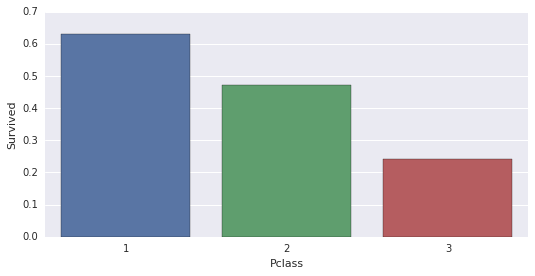

In [5]:
sns.factorplot(x='Pclass',y='Survived',data=Train,kind ='bar',ci=None,aspect=1.9)

### Decision Tree Modeling
It is evident that passenger with Pclass 1 actually had a better survival ratio. Lets use this feature and quickly build our model. We will be using Decision tree classifier with 25 fold crossvalidation strategy. This means that our training set is partitioned into 25 parts (24 parts as training set and 1 part as develpment set). We will report the score on the development set. Further we are tuning the hyperparameter using gridsearch for best results.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_


0.67901234567901236

67.9% accuracy!! Not bad for a start. Lets analyse another feature __SibSp__.Let us look at its distribution. 

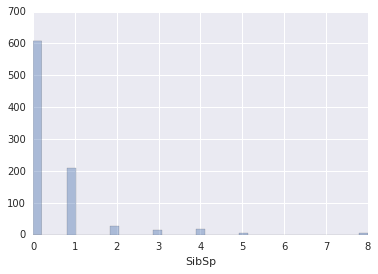

In [7]:
sns.distplot(Train['SibSp'],kde=False)


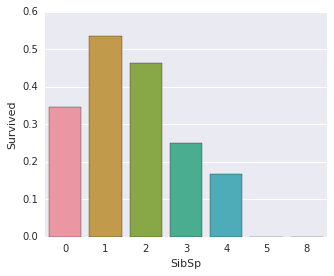

In [8]:
sns.factorplot(x='SibSp',y='Survived',data=Train,kind='bar',aspect=1.2,ci=None)


From the plots it is clear that most passengers didn't have siblings or spouses although the survival rate for them is relatively low when compared to passengers having 1 or 2 SibSp.
Lets analyse the correlation of __Pclass__ and __Sibsp__ with taget __Survived__


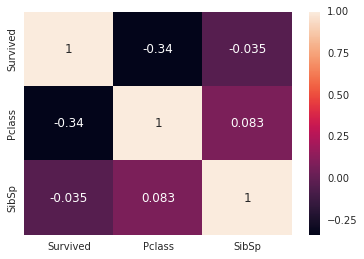

In [9]:
corr = Train[['Survived','Pclass','SibSp']].corr()
sns.heatmap(corr,annot=True)

___Pclass__ is significantly correlated with survival. There is a weak correlation of __Pclass__ and __SibSp__. We will keep both of these features for our model. Also __SibSp__ is weakly correlated with __Survived__. Lets add these features and build our model.

In [10]:
X = Train[['Pclass','SibSp']]  # Feature vector
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_


0.68237934904601572

Boost of 0.03%. Small boost seems to be due to weaker correlation of __Survived__ and __SibSp__. Lets move onto __Parch__.

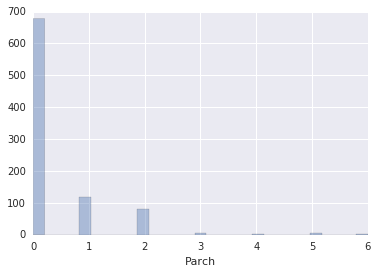

In [11]:
sns.distplot(Train['Parch'],kde=False)


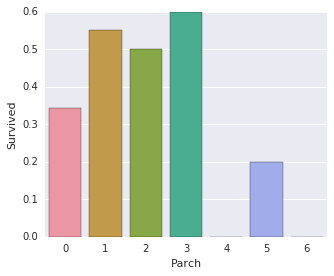

In [12]:
sns.factorplot(x='Parch',y='Survived',data=Train,kind='bar',aspect=1.2,ci=None)


From distribution of __Parch__, most passengers didn't travel with children or parents. But those who did travel with parents/children had a better chance of surviving than those who were alone. Lets look at the correlation matrix again.

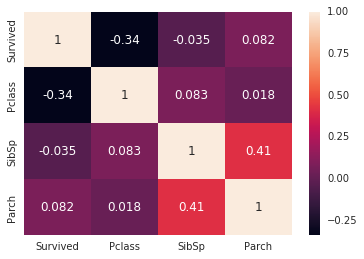

In [13]:
corr = Train[['Survived','Pclass','SibSp','Parch']].corr()
sns.heatmap(corr,annot=True)

__Parch__ is weakly correlated with Survival. Lets see its impact on our model.

In [14]:
X = Train[['Pclass','SibSp','Parch']]  # Feature vector
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_


0.71043771043771042

Oh increase of 0.3% !!. __Parch__  is definetely a key feature. In previous analysis we had seen that most passengers didn't have SibSp or Parch. Lets combine these two features and create a new feature called Family (reference) which is addition of these two features indicating whether passenger was travelling alone or with family.  

In [15]:
Train['Family'] = Train['SibSp']+Train['Parch']+1

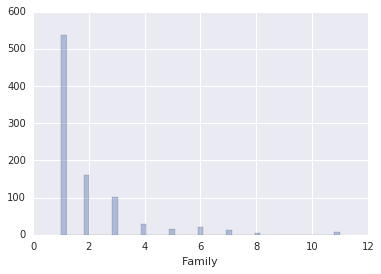

In [16]:
sns.distplot(Train['Family'],kde=False)

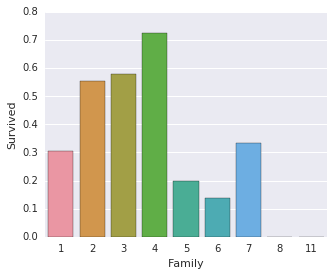

In [17]:
sns.factorplot(x='Family',y='Survived',data=Train,kind='bar',aspect=1.2,ci=None)


Again from the plots it is evident that most passengers travelled alone but had a smaller survival ratio when compared to the passengers who travelled with family. Lets add these feature and see if the model gets improved.

In [18]:
X = Train[['Pclass','SibSp','Parch','Family']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_


0.71156004489337821

Not a large increase huh. Lets move onto our next feature __Sex__. We expect women to have better survival chance then men. Its time to check our hypothesis.

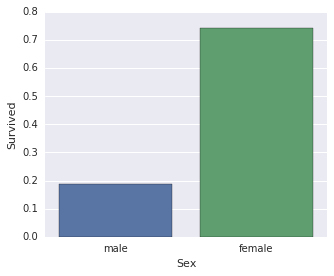

In [19]:
sns.factorplot(x='Sex',y='Survived',data=Train,kind='bar',aspect=1.2,ci=None)

Our hypothesis seems to be correct. Lets map __Sex__ to a numerical value with 0 indicating male and 1 indicating female.

In [20]:
Train['Sex'] = Train['Sex'].map({'male':0,'female':1})

Lets see the correlation matrix again.

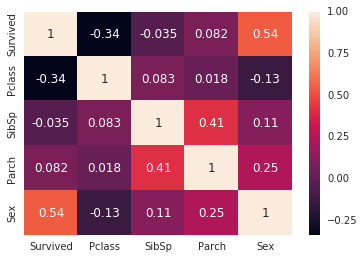

In [21]:
corr = Train[['Survived','Pclass','SibSp','Parch','Sex']].corr()
sns.heatmap(corr,annot=True)

Sex is the most correlated feature with Survival. Lets see its impact on our model.

In [22]:
X = Train[['Pclass','SibSp','Parch','Family','Sex']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_


0.80246913580246915

We touched __80%__ accuracy !! Now thats call improvement. And we have many more features to include which implies lot of room for improvement. Lets keep going and add another feature __Fare__. But first lets have a look at __Ticket__ column.

In [23]:
Train['Ticket'].isnull().sum()


0

In [24]:
Train['Ticket'].nunique()

681

There are 681 unique values of tickets for 891 examples and there are no null values. That means tickets were shared among passengers. Now lets check Fare of the passengers with same ticket.

In [25]:
Train.groupby('Ticket')['Fare'].value_counts()

Ticket             Fare    
110152             86.5000     3
110413             79.6500     3
110465             52.0000     2
110564             26.5500     1
110813             75.2500     1
111240             33.5000     1
111320             38.5000     1
111361             57.9792     2
111369             30.0000     1
111426             26.5500     1
111427             26.5500     1
111428             26.5500     1
112050             0.0000      1
112052             0.0000      1
112053             30.0000     1
112058             0.0000      1
112059             0.0000      1
112277             31.0000     1
112379             39.6000     1
113028             26.5500     1
113043             28.5000     1
113050             26.5500     1
113051             27.7500     1
113055             26.5500     1
113056             26.0000     1
113059             47.1000     1
113501             30.0000     1
113503             211.5000    1
113505             55.0000     2
113509         

If we look at ticket name 110152, the Fare is same for all passengers. This means that Fare actually indicates total Fare of that ticket for all passengers and not Fare per passenger. We will transform the column fare to indicate the true value per passenger rather than total sum.

In [26]:
Train['Fare']=Train.groupby('Ticket')['Fare'].apply(lambda x : x/len(x))
Train.groupby('Ticket')['Fare'].value_counts()


Ticket             Fare      
110152             28.833333     3
110413             26.550000     3
110465             26.000000     2
110564             26.550000     1
110813             75.250000     1
111240             33.500000     1
111320             38.500000     1
111361             28.989600     2
111369             30.000000     1
111426             26.550000     1
111427             26.550000     1
111428             26.550000     1
112050             0.000000      1
112052             0.000000      1
112053             30.000000     1
112058             0.000000      1
112059             0.000000      1
112277             31.000000     1
112379             39.600000     1
113028             26.550000     1
113043             28.500000     1
113050             26.550000     1
113051             27.750000     1
113055             26.550000     1
113056             26.000000     1
113059             47.100000     1
113501             30.000000     1
113503             211.50

Now that we have the true Fare, lets see its distribution. 

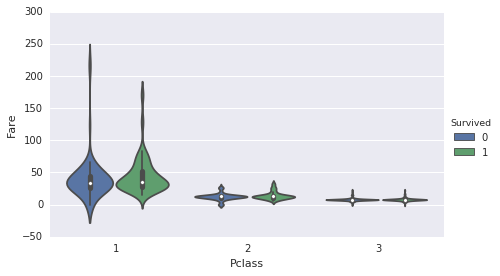

In [27]:
sns.factorplot(x='Pclass',y='Fare',hue='Survived',data=Train,kind='violin',aspect=1.6)

As expected Pclass 1 has higher mean fare when compared to Pclass 2 and 3. Lets see its correlation with survival.

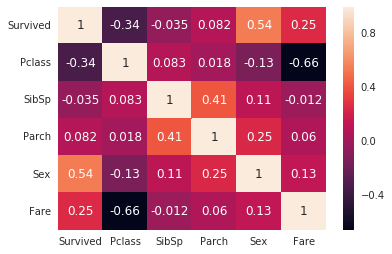

In [28]:
corr = Train[['Survived','Pclass','SibSp','Parch','Sex','Fare']].corr()
sns.heatmap(corr,annot=True)

__Fare__ does have some correlation with Survival of passengers. Lets add this to our model and check our new score 

In [29]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
len(X.columns)

6

Aha!! Increase of 0.29 % in accuracy. Lets continue with our analysis. Lets now look at __Embarked__. These feature has 2 missing entries. Lets look at these entries and map to numerical values.

In [30]:
Train[Train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,40.0,B28,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,40.0,B28,NaN,1


In [31]:
Train['Embarked'] = Train['Embarked'].map({'C':0,'Q':1,'S':2})
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,26.5500,C123,2.0,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0,1


As we have limited data for training we wont drop any training examples. So we will have to impute the missing values. Now, one logical way to think is that place where passengers embarked influences their fare which in turn influences Pclass to some extent. So lets guess the embarked location from their Pclass.

In [32]:
Train['Embarked'] = Train.groupby(['Pclass']) ['Embarked'].apply(lambda x:x.fillna(x.median()))

In [33]:
Train[['Ch','Q','S']]= pd.get_dummies(Train['Embarked'])


In [34]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
len(X.columns)

9

So we get a drop of 0.2 %. Lets continue adding features and we'll decide later about dropping features. Now lets analyse the feature __Name__. We will extract the title from the name of the passengers  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


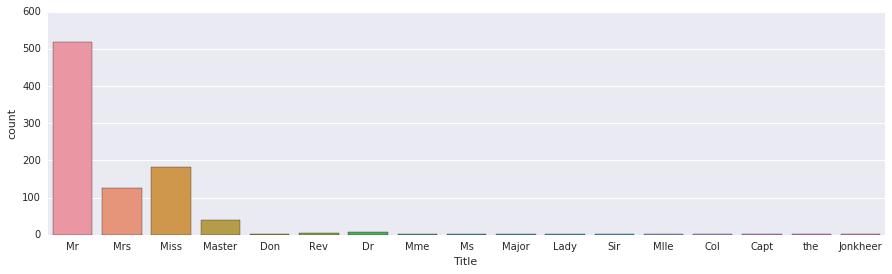

In [35]:
Train['Title'] = Train['Name'].str.extract('.+,\s(\w*).+')
plt.figure(figsize=(15,4))
sns.countplot(Train["Title"])


As we see from the distribution of Title [Mr,Mrs,Miss,Master] dominates. So we can club the other categories as one 
category called Rare. Lets do that .

In [36]:
Train['Title'] = Train['Title'].replace(['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','the','Jonkheer','Mme','Ms','Mlle'],'Rare')


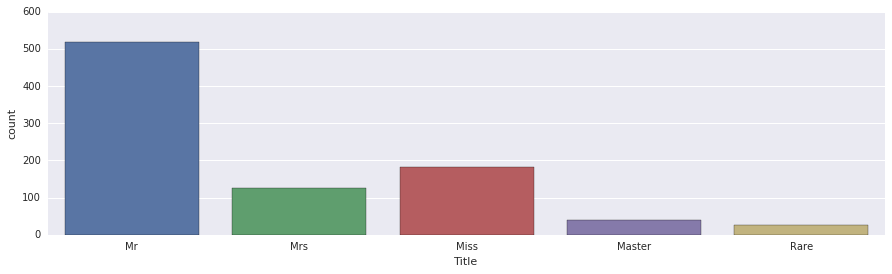

In [37]:
plt.figure(figsize=(15,4))
sns.countplot(Train["Title"])

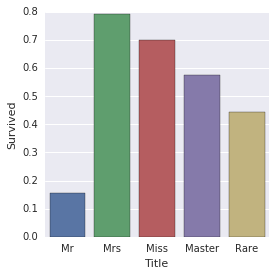

In [38]:
sns.factorplot(x='Title',y='Survived',data=Train,kind='bar',ci=None)

So Title affects a lot. Passengers with title 'Mr' are not so lucky as indicated from the plots. Now we will generate features corresponding to each category.

In [39]:
Train = pd.concat([Train, pd.get_dummies(Train['Title'])], axis=1); 

In [40]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
len(X.columns)

9

Okay we are back to 82%. And we still have few features to look at.

Lets look at the feature __Age__. It has lots of missing values. We will impute these missing values on the basis of their titles. Precisely, we will group them by Title and then Nan are replaced by their group mean. 

In [41]:
Train["Age"]  = Train.groupby("Title")['Age'].transform(lambda x: x.fillna(x.mean()))


So now that we have filled the missing values, lets have a look at the distribution of __age__.

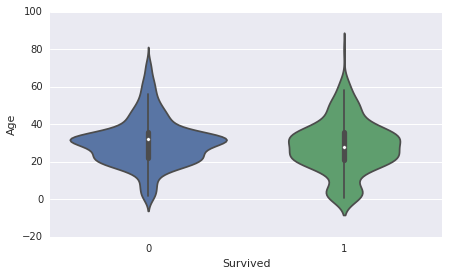

In [42]:
sns.factorplot(x='Survived',y='Age',data=Train,kind='violin',aspect=1.6)

Age does not seem to be a deciding factor looking at the above plots. Lets add __Age__ to our features and check.

In [43]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Age']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
len(X.columns)

15

Adding age seems to decrease the performance. Lets divide Age in 2 categories adult and children and then see its impact

In [44]:
Train['age'] = Train['Age'].apply(lambda Age: 'Adult' if Age > 15 else 'Child') 
Train = pd.concat([Train, pd.get_dummies(Train['age'])], axis=1); Train.drop('age',1);

Now lets add them to our feature set and build our model again.

In [45]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
len(X.columns)

16

yay !! We have recovered our accuracy of 82% just by dividing Age into 2 bins. 

Now we have two more features. __Cabin__ and __Ticket__. Cabin has lots of missing values and some entries have multiple cabins.

In [46]:
Train['Cabin'].value_counts(dropna=0)

NaN                687
G6                   4
C23 C25 C27          4
B96 B98              4
F2                   3
C22 C26              3
E101                 3
F33                  3
D                    3
C126                 2
E44                  2
B5                   2
C123                 2
F G73                2
C52                  2
C124                 2
C78                  2
D36                  2
D35                  2
D33                  2
C93                  2
B77                  2
B22                  2
E67                  2
B28                  2
B57 B59 B63 B66      2
E33                  2
C92                  2
B18                  2
C2                   2
                  ... 
A19                  1
F G63                1
E12                  1
C47                  1
E46                  1
A6                   1
B4                   1
B71                  1
A20                  1
D46                  1
A23                  1
D47                  1
A26        

This means the cabins might have been shared by passengers. Lets look at the tickets and cabins simultaneously.

In [47]:
Train.groupby('Ticket')['Cabin'].value_counts(dropna=0)

Ticket             Cabin
110152             B77      2
                   B79      1
110413             E67      2
                   E68      1
110465             A14      1
                   C110     1
110564             C52      1
110813             D37      1
111240             B19      1
111320             E63      1
111361             B18      2
111369             C148     1
111426             NaN      1
111427             NaN      1
111428             NaN      1
112050             A36      1
112052             NaN      1
112053             B42      1
112058             B102     1
112059             B94      1
112277             A31      1
112379             NaN      1
113028             C124     1
113043             C124     1
113050             B38      1
113051             C111     1
113055             E17      1
113056             A19      1
113059             NaN      1
113501             D6       1
                           ..
SOTON/OQ 392082    NaN      1
SOTON/OQ 392086

lets pull out rows corresponding to ticket=110152

In [48]:
Train[Train['Ticket']=='110152'][['Cabin','Fare','Name','Age']]

,Cabin,Fare,Name,Age
257,B77,28.833333,"Cherry, Miss. Gladys",30.0
504,B79,28.833333,"Maioni, Miss. Roberta",16.0
759,B77,28.833333,"Rothes, the Countess. of (Lucy Noel Martha Dye...",33.0


What we can do is to extract first cabin letter and then fill Nan values with same cabin grouped by same ticket.

In [49]:
Train['Cab'] = Train['Cabin'].str.extract('(\w)')
Train['Cab']=Train.groupby('Ticket')['Cab'].apply(lambda x:x.fillna(method='bfill').fillna(method='ffill').fillna(method='bfill'))
Train['Cab'] = Train['Cab'].replace(np.nan,'Other')
Train.groupby('Ticket')['Cab'].value_counts(dropna=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


Ticket             Cab  
110152             B        3
110413             E        3
110465             A        1
                   C        1
110564             C        1
110813             D        1
111240             B        1
111320             E        1
111361             B        2
111369             C        1
111426             Other    1
111427             Other    1
111428             Other    1
112050             A        1
112052             Other    1
112053             B        1
112058             B        1
112059             B        1
112277             A        1
112379             Other    1
113028             C        1
113043             C        1
113050             B        1
113051             C        1
113055             E        1
113056             A        1
113059             Other    1
113501             D        1
113503             C        1
113505             E        2
                           ..
SOTON/OQ 392082    Other    1
SOTON/OQ 392086

In [50]:
Train = pd.concat([Train, pd.get_dummies(Train['Cab'])], axis=1)


In [51]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child','A','B','C','D','E','F','G','T','Other']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf = GridSearchCV(dtree,parameters,cv=25)
clf.fit(X,Y)
clf.best_score_
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
Pclass    891 non-null int64
SibSp     891 non-null int64
Parch     891 non-null int64
Family    891 non-null int64
Sex       891 non-null int64
Fare      891 non-null float64
Ch        891 non-null uint8
Q         891 non-null uint8
S         891 non-null uint8
Mr        891 non-null uint8
Mrs       891 non-null uint8
Miss      891 non-null uint8
Rare      891 non-null uint8
Master    891 non-null uint8
Adult     891 non-null uint8
Child     891 non-null uint8
A         891 non-null uint8
B         891 non-null uint8
C         891 non-null uint8
D         891 non-null uint8
E         891 non-null uint8
F         891 non-null uint8
G         891 non-null uint8
T         891 non-null uint8
Other     891 non-null uint8
dtypes: float64(1), int64(5), uint8(19)
memory usage: 58.4 KB


We are still at 82 %. Now lets add test data and see if we have to impute values.

In [52]:
Test = pd.read_csv('test.csv')
pid =Test['PassengerId']
Test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We have missing values for age,fare and cabin. We will guess Age again by first filling with group mean value based on Title (Training data) and then categorise if the passenger is adult or child.
Embarked will be guessed based on Pclass and Cabin will be filled with same value as ticket(if available or else keep it as Nan) 

In [53]:
Test['Sex'] = Test['Sex'].map({'male':0,'female':1})
Test['Title'] = Test['Name'].str.extract('.+,\s(\w*).+') 
Test.head()



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [54]:
Test['Title'] = Test['Title'].replace(['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','the','Jonkheer','Mme','Ms','Mlle','Dona'],'Rare')    
Test['Embarked'] = Test['Embarked'].map({'C':0,'Q':1,'S':2})
Test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,2,Mrs
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,Mr
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,2,Mrs


In [55]:
df = pd.DataFrame(Train.groupby('Title')['Age'].mean()) ## Get the mean age for each title from training set 
#df['Title'] = df.index
Test=Test.merge(df,left_on='Title',right_index=True)
Test['Age']= Test['Age_x'].fillna(Test['Age_y'])
#Test.drop(['Age_x','Age_y'],axis=1,inplace=1)
Test['Age'].isnull().sum()
Test.head()

,PassengerId,Pclass,Name,Sex,Age_x,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_y,Age
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,Mr,32.36809,34.5
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,Mr,32.36809,62.0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,Mr,32.36809,27.0
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,2,Mr,32.36809,14.0
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,2,Mr,32.36809,26.0


Missing Age values are now filled with thier respective means. Now lets fill missing Fare values. 
Fare is determined by Pclass of the passenger and the embarked location. 

In [56]:
Test['Fare']=Test.groupby('Ticket')['Fare'].apply(lambda x : x/len(x))
df =  pd.DataFrame(Train.groupby(['Pclass','Embarked'])['Fare'].mean())

Test = Test.merge(df,how='left',left_on=['Pclass','Embarked'],right_index=True)
Test['Fare']= Test['Fare_x'].fillna(Test['Fare_y'])
#Test.drop(['Fare_x','Fare_y'],axis=1,inplace=1)
Test.head()

,PassengerId,Pclass,Name,Sex,Age_x,SibSp,Parch,Ticket,Fare_x,Cabin,Embarked,Title,Age_y,Age,Fare_y,Fare
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,Mr,32.36809,34.5,7.925754,7.8292
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,Mr,32.36809,62.0,12.350000,9.6875
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,Mr,32.36809,27.0,8.140477,8.6625
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,2,Mr,32.36809,14.0,8.140477,9.2250
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,2,Mr,32.36809,26.0,13.155183,29.0000


Now that Fare has been taken care of. Lets fill the missing cabin values using our previous method.

In [57]:
Test['Cab'] = Test['Cabin'].str.extract('(\w)')
Test['Cab']=Test.groupby('Ticket')['Cab'].apply(lambda x:x.fillna(method='bfill').fillna(method='ffill').fillna(method='bfill'))
Test['Cab'] = Test['Cab'].replace(np.nan,'Other')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


Further it may happen that tickets were shared by the passengers in the test set with passengers in the Training Set. Let use this knowledge too.  

In [58]:
df = Train.merge(Test,on='Ticket',how='left')
Test['Cab'] = df['Cab_y'].fillna(df['Cab_x'])
Test.head()

,PassengerId,Pclass,Name,Sex,Age_x,SibSp,Parch,Ticket,Fare_x,Cabin,Embarked,Title,Age_y,Age,Fare_y,Fare,Cab
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,Mr,32.36809,34.5,7.925754,7.8292,Other
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,Mr,32.36809,62.0,12.350000,9.6875,Other
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,Mr,32.36809,27.0,8.140477,8.6625,C
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,2,Mr,32.36809,14.0,8.140477,9.2250,Other
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,2,Mr,32.36809,26.0,13.155183,29.0000,Other


After filling up all the values lets build our Test features

In [59]:
Test = pd.concat([Test, pd.get_dummies(Test['Cab'])], axis=1)
Test['age'] = Test['Age'].apply(lambda Age: 'Adult' if Age > 15 else 'Child') 
Test = pd.concat([Test, pd.get_dummies(Test['age'])], axis=1); Test.drop('age',1)
Test[['Ch','Q','S']]= pd.get_dummies(Test['Embarked'])
Test = pd.concat([Test, pd.get_dummies(Test['Title'])], axis=1); 
Test['Family'] = Test['SibSp']+Test['Parch']+1

Test.head()

,PassengerId,Pclass,Name,Sex,Age_x,SibSp,Parch,Ticket,Fare_x,Cabin,...,Child,Ch,Q,S,Master,Miss,Mr,Mrs,Rare,Family
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,...,0,0,1,0,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,...,0,0,1,0,0,0,1,0,0,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,...,0,0,0,1,0,0,1,0,0,1
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,...,1,0,0,1,0,0,1,0,0,1
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,...,0,0,0,1,0,0,1,0,0,3


In [60]:
X_Test = Test[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child','A','B','C','D','E','F','G','T','Other']] 

X_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 414
Data columns (total 25 columns):
Pclass    418 non-null int64
SibSp     418 non-null int64
Parch     418 non-null int64
Family    418 non-null int64
Sex       418 non-null int64
Fare      418 non-null float64
Ch        418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
Mr        418 non-null uint8
Mrs       418 non-null uint8
Miss      418 non-null uint8
Rare      418 non-null uint8
Master    418 non-null uint8
Adult     418 non-null uint8
Child     418 non-null uint8
A         418 non-null uint8
B         418 non-null uint8
C         418 non-null uint8
D         418 non-null uint8
E         418 non-null uint8
F         418 non-null uint8
G         418 non-null uint8
T         418 non-null uint8
Other     418 non-null uint8
dtypes: float64(1), int64(5), uint8(19)
memory usage: 30.6 KB


In [61]:
pred = clf.best_estimator_.predict(X_Test)
res = pd.DataFrame(Test['PassengerId'])
res['Survived'] = pred
res.to_csv('result.csv',index =False)

Lets try training on other models and select the best classifier among them 

In [62]:
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child']] 
dtree = DecisionTreeClassifier()
parameters = [{'criterion':['gini','entropy'],'max_depth':[1,10,20,50,100],'min_samples_split':[2,10,20,30,40,50]}]
clf_dtree = GridSearchCV(dtree,parameters,cv=25)
clf_dtree.fit(X,Y)
clf_dtree.best_score_

0.82267115600448937

In [63]:
from sklearn.ensemble import AdaBoostClassifier
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child']] 
Ada = AdaBoostClassifier()
parameters = [{'n_estimators':[1,10,20,50,100],'learning_rate':[0.1,0.2,0.4,0.6,1]}]
clf_ada = GridSearchCV(Ada,parameters,cv=25)
clf_ada.fit(X,Y)
clf_ada.best_score_

0.83277216610549942

In [64]:
from sklearn.ensemble import RandomForestClassifier
X = Train[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child']] 
dFor = RandomForestClassifier() 
parameters = [{'n_estimators':[5,10,20,50],'criterion':['gini','entropy']}]
clf_dfor = GridSearchCV(dFor,parameters,cv=25)
clf_dfor.fit(X,Y)
clf_dfor.best_score_
#print(clf.cv_results_['mean_test_score'])

#print(clf.cv_results_['mean_train_score'])

#print(clf.best_params_)

0.8058361391694725

Clearly adaboost classifier performs better so we will run the final model on that classifier 

In [66]:
X_Test = Test[['Pclass','SibSp','Parch','Family','Sex','Fare','Ch','Q','S','Mr','Mrs','Miss','Rare','Master','Adult','Child']] 
pred = clf_ada.best_estimator_.predict(X_Test)
res = pd.DataFrame(Test['PassengerId'])
res['Survived'] = pred
res.to_csv('result.csv',index =False)
